## For plotting licking data, e.g. Fig. 1c, ED Fig. 1f-g, 8b, 10c

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns
from cycler import cycler
from traceUtils import *
import numpy as np
from scipy import stats
from scipy.stats import sem, friedmanchisquare, wilcoxon
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import mixedlm
import os
import pickle
import sys
sys.path.append('../utils')
from protocols import get_cs_info, load_params
from db import get_db_info, select_db, execute_sql
from plotting import plot_avgs, hide_spines, summarize_behavior, get_mouse_colors
from matio import loadmat
sys.path.append('../neural_analysis')
from analysisUtils import construct_where_str

In [4]:
plt.style.use('paper_export')

In [5]:
# choose one block to uncomment to select protocol
protocol = 'SameRewDist'
xtickpos = [0.5, 2.5, 4.5]
xticklabs = ['Nothing', 'Fixed', 'Variable']

# protocol = 'Bernoulli'
# xticklabs = ['0', '20', '50', '80', '  100%']
# xtickpos = np.arange(len(xticklabs))

# protocol = "DiverseDists" 
# xticklabs = ['CS1 ', '2', '3', '4', '5', '6']
          
# protocol = 'SameRewVar'
# xtickpos = [0.5, 2.5, 4.5]
# xticklabs = ['Nothing', 'Uniform', 'Bimodal']

In [7]:
# chooose either has_ephys or has_imaging = 1
colors, protocol_info, periods, kwargs = load_params(protocol)
kwargs['has_ephys'] = 1  # only get ephys sessions that we're using. e.g. Fig. 1c, ED Fig. 8b
# kwargs['has_imaging'] = 1  # only get imaging sessions that we're using. ED Fig. 10c

In [8]:
### General Parameters ###
if 'has_imaging' in kwargs:
    class_name = 'genotype' 
    class_labels = ['D1-Cre', 'A2a-Cre'] 
else:
    class_name = 'helper'
    class_labels = ['all']
    
n_trace_types = protocol_info['n_trace_types']
trace_type_names = protocol_info['trace_type_names']
po = np.argsort(protocol_info['mean'][:n_trace_types])


# colors, vline_color, trial_type_names, trace_type_names, n_trial_types, n_trace_types, variable_rew_css = get_cs_info(protocol)
# dbinfo, plot_roots, data_roots, pool, ON_CLUSTER = get_db_info(make_pool=False)
paths = get_db_info()
alpha = 0.05  # for significance testing

# create SQL query based on keyword arguments passed to function
where_str = ['protocol="' + protocol.replace('DiverseDists', 'DistributionalRL_6Odours') + '"']
where_vals = []
for key, val in zip(kwargs.keys(), kwargs.values()):
    if val is not None:
        if key == 'code':
            where_str.append('name IN(SELECT name FROM mouse WHERE code IN ' + str(val) + ' OR code IS NULL)')
#             where_vals.append(str(val))
        elif key in ['n_trial', 'quality', 'phase', 'image']:
            where_str.append(key + '>=?')
            where_vals.append(val)
        elif key in ['significance', 'has_imaging', 'has_ephys', 'rigname']:
            where_str.append(key + '=?')
            where_vals.append(val)
        elif key in ['name']:
            where_str.append(key + ' IN ' + str(val))
        elif key in ['has_recording']:
            where_str.append('(has_imaging=? OR has_ephys=?)')
            where_vals.extend([val, val])
        elif key == 'exclude_names':
            where_str.append('name NOT IN ' + str(val))

where_str = ' AND '.join(where_str)

# get all sessions matching this query
rets = select_db(paths['db'], 'session', '*', 'figure_path IS NOT NULL AND ' + where_str, where_vals, unique=False)

# deal with stats kwarg case, which requires reading in the entire JSONified string of the table
rets = check_stats(rets, kwargs['stats'], protocol_info['pairs_to_check'])

In [9]:
ret_df = pd.DataFrame(rets, columns=rets[0].keys())
n_sess = len(ret_df)

In [19]:
table = 'ephys' if 'has_ephys' in kwargs and kwargs['has_ephys'] else 'imaging'
data_path = os.path.join(paths['behavior_root'], f'licking_{protocol}_{table}.p')
with open(data_path, 'rb') as f:
    data = pickle.load(f)

# bring loaded variables into namespace
for var in data.keys():
    exec("{} = data['{}']".format(var, var))

In [31]:
if 'Same' in protocol:
    var_path = os.path.join(paths['behavior_root'], f'var_licking_{protocol}_{table}.p')
    with open(var_path, 'rb') as f:
        vdata = pickle.load(f)

# bring loaded variables into namespace
for var in vdata.keys():
    exec("{} = vdata['{}']".format(var, var))

In [33]:
mouse_rets = select_db(paths['db'], 'mouse', 'name, genotype', 'TRUE', (), unique=False)
mouse_df = pd.DataFrame(mouse_rets, columns=mouse_rets[0].keys())
mouse_df['genotype'] = mouse_df['genotype'].str.split(" ", n=1, expand=True)[0]
if class_name == 'genotype':
    ret_df = ret_df.merge(mouse_df, on='name', validate='many_to_one')
else:
    ret_df['helper'] = 'all'

In [34]:
ddict = {'lick_diffs': (last_sec_means - baseline_lick_means).flatten(),
         'licks': last_sec_means.flatten(),
         'tt': np.repeat(protocol_info['trace_type_names'], n_sess),
         'i_tt': np.repeat(np.arange(protocol_info['n_trace_types']), n_sess),
         'name': np.tile(ret_df['name'], protocol_info['n_trace_types']),
         'figure_path': np.tile(ret_df['figure_path'], protocol_info['n_trace_types']),
         class_name: np.tile(ret_df[class_name], protocol_info['n_trace_types'])
         }
df = pd.DataFrame(ddict)

In [35]:
# run a bunch of statistical tests on the data
# relative to each possible odor
for i_tt in range(n_trace_types):
    dfmod = df.copy()
    dfmod.loc[dfmod['i_tt'] == i_tt, 'i_tt'] = -1
    formula = f'licks ~ C(i_tt) * {class_name}'
    model = mixedlm(formula, dfmod, groups='name')
    mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
    print(mfit.summary())

                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      licks     
No. Observations:        624          Method:                  REML      
No. Groups:              12           Scale:                   1.3982    
Min. group size:         18           Log-Likelihood:          -1004.6197
Max. group size:         126          Converged:               Yes       
Mean group size:         52.0                                            
-------------------------------------------------------------------------
               Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
-------------------------------------------------------------------------
Intercept    1.944e-01 1.663e-01 1.169e+00 2.423e-01 -1.315e-01 5.203e-01
C(i_tt)[T.1] 1.616e-02 1.640e-01 9.855e-02 9.215e-01 -3.052e-01 3.376e-01
C(i_tt)[T.2] 2.670e+00 1.640e-01 1.628e+01 1.266e-59  2.349e+00 2.992e+00
C(i_tt)[T.3] 2.560e+00 1.640e-01 1.561e+01 5.937e-55  2.

In [36]:
# relative to each possible odor, separately for each class
for class_label in class_labels:
    print(class_label)
    for i_tt in range(n_trace_types):
        dfmod = df[df[class_name] == class_label].copy()
        dfmod.loc[dfmod['i_tt'] == i_tt, 'i_tt'] = -1
        formula = f'licks ~ C(i_tt) * {class_name}'
        model = mixedlm(formula, dfmod, groups='name')
        mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
        print(mfit.summary())

all
                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      licks     
No. Observations:        624          Method:                  REML      
No. Groups:              12           Scale:                   1.3982    
Min. group size:         18           Log-Likelihood:          -1004.6197
Max. group size:         126          Converged:               Yes       
Mean group size:         52.0                                            
-------------------------------------------------------------------------
               Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
-------------------------------------------------------------------------
Intercept    1.944e-01 1.663e-01 1.169e+00 2.423e-01 -1.315e-01 5.203e-01
C(i_tt)[T.1] 1.616e-02 1.640e-01 9.855e-02 9.215e-01 -3.052e-01 3.376e-01
C(i_tt)[T.2] 2.670e+00 1.640e-01 1.628e+01 1.266e-59  2.349e+00 2.992e+00
C(i_tt)[T.3] 2.560e+00 1.640e-01 1.561e+01 5.937e-55

[ 79  80  81  87  89  94  95 117 119 121 122 123]
104
figs/SameRewDist_helper_behavior_all


meta NOT subset; don't know how to subset; dropped


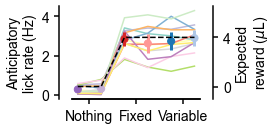

In [37]:
# plot averages across mice, within class
mouse_colors = get_mouse_colors(protocol) if 'has_ephys' in kwargs else get_mouse_colors(protocol, imaging=True)
mids = ret_df['mid']

for class_label in class_labels:

    rows_use = ret_df.loc[ret_df[class_name] == class_label, ['mid', 'name']]
    mid_arr = np.unique(rows_use['mid'])
    print(mid_arr)
    print(np.sum(np.isin(mids, mid_arr)))
    class_colors = {k: v for k, v in mouse_colors.items() if k in rows_use['name'].values}
    savename = os.path.join('figs', '_'.join([protocol, class_name, 'behavior', class_label]))
    
    # compute means within mice
    licking_timecourse_mouse = np.swapaxes(np.array([np.mean(licking_timecourse[:, mids == i_mid, :], axis=1) 
                                                     for i_mid in mid_arr]), 0, 1)
    last_sec_means_mouse = np.swapaxes(np.array([np.mean(last_sec_means[:, mids == i_mid], axis=1) 
                                                 for i_mid in mid_arr]), 0, 1)
    trace_lick_means_mouse = np.swapaxes(np.array([np.mean(trace_lick_means[:, mids == i_mid], axis=1) 
                                                   for i_mid in mid_arr]), 0, 1)
    
    summarize_behavior(last_sec_means_mouse, n_trace_types, protocol_info, colors, po, savename, 'mice',
                       xticklabs, xtickpos, mouse_colors=class_colors)
    plt.show()

figs/SameRewDist_helper_behavior_diffs_all


meta NOT subset; don't know how to subset; dropped


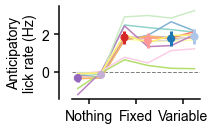

In [38]:
for class_label in class_labels:
    
    mids_use = ret_df.loc[ret_df[class_name] == class_label, 'mid']
    mid_arr = np.unique(mids_use)
    
    # compare late trace licking to baseline
    savename = os.path.join('figs', '_'.join([protocol, class_name, 'behavior_diffs', class_label]))
    baseline_diffs_mouse = np.swapaxes(np.array([np.mean((last_sec_means - baseline_lick_means)[:, mids == i_mid], axis=1) 
                                                   for i_mid in mid_arr]), 0, 1)
    summarize_behavior(baseline_diffs_mouse, n_trace_types, protocol_info, colors, po, savename, 'mice',
                       xticklabs, xtickpos, mouse_colors=mouse_colors, hline=0)

In [39]:
# differences relative to baseline
for i_tt in range(n_trace_types):
    formula = f'lick_diffs ~ {class_name}'
    model = mixedlm(formula, df[df['i_tt'] == i_tt], groups='name')
    mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
    print(mfit.summary())

                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      lick_diffs
No. Observations:        104          Method:                  REML      
No. Groups:              12           Scale:                   0.3709    
Min. group size:         3            Log-Likelihood:          -103.5822 
Max. group size:         21           Converged:               Yes       
Mean group size:         8.7                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -3.962e-01 1.120e-01 -3.537e+00 4.054e-04 -6.158e-01 -1.766e-01
name Var   9.841e-02 1.333e-01                                           

                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      lick_diffs

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     lick_diffs
No. Observations:      104         Method:                 REML      
No. Groups:            12          Scale:                  1.7220    
Min. group size:       3           Log-Likelihood:         -181.1959 
Max. group size:       21          Converged:              Yes       
Mean group size:       8.7                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.322e+00 2.124e-01 1.093e+01 7.943e-28 1.906e+00 2.738e+00
name Var  2.962e-01 2.123e-01                                        

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     lick_diffs
No. Observations:      104         Method:         

<ipython-input-40-d6ed45925162>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mousevar_df = vardf.groupby(['tt', 'prev_rew', 'name'], as_index=False).mean()
meta NOT subset; don't know how to subset; dropped
<ipython-input-40-d6ed45925162>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = mousevar_df.groupby(['prev_rew', 'name'], as_index=False).mean()
meta NOT subset; don't know how to subset; dropped


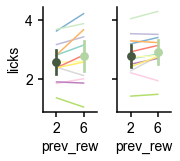

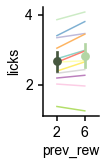

In [40]:
# compare late trace licking on variable trials following 2 vs. 6 uL
if 'Same' in protocol:
    vardict = {'licks': var_means.flatten(),
               'tt': np.repeat([f'{var_name} 1', f'{var_name} 2'], n_sess * n_var_rews),
               'i_tt': np.repeat(var_inds, n_sess * n_var_rews),
               'prev_rew': np.tile(np.repeat(['2', '6'], n_sess), n_var_tts),
               'name': np.tile(ret_df['name'], n_var_tts * n_var_rews),
               'figure_path': np.tile(ret_df['figure_path'], n_var_tts * n_var_rews)
    }
    vardf = pd.DataFrame(vardict)
    
    # for plotting
    mousevar_df = vardf.groupby(['tt', 'prev_rew', 'name'], as_index=False).mean()
    # mousevar_df

    g = sns.FacetGrid(data=mousevar_df, col='tt', height=2.7, aspect=0.5)
    g.map_dataframe(sns.lineplot, x='prev_rew', y='licks', hue='name', palette=mouse_colors, estimator=None, zorder=1)
    g.map_dataframe(sns.pointplot, x='prev_rew', y='licks', hue='prev_rew', palette=['#475840', '#b3d5a4']).set_titles("")
    plt.savefig(os.path.join('figs', protocol + '_prev_rew_diffs_var_1_2.pdf'))
    
    plt.figure(figsize=(1, 2))
    data = mousevar_df.groupby(['prev_rew', 'name'], as_index=False).mean()
    ax = sns.lineplot(data=data, x='prev_rew', y='licks', hue='name', palette=mouse_colors, estimator=None, zorder=1, legend=False)
    sns.pointplot(data=mousevar_df, x='prev_rew', y='licks', hue='prev_rew', ax=ax, palette=['#475840', '#b3d5a4'])
    plt.legend().remove()
    hide_spines()
    plt.savefig(os.path.join('figs', protocol + '_prev_rew_diffs_var_pooled.pdf'))

In [41]:
if 'Same' in protocol:
    formula = 'licks ~ C(prev_rew)'
    model = mixedlm(formula, vardf, groups='name')
    mfit = model.fit(method=['powell', 'lbfgs'], maxiter=2000)
    print(mfit.summary())

                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        licks    
No. Observations:         416            Method:                    REML     
No. Groups:               12             Scale:                     2.0098   
Min. group size:          12             Log-Likelihood:            -748.3579
Max. group size:          84             Converged:                 Yes      
Mean group size:          34.7                                               
-----------------------------------------------------------------------------
                   Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
-----------------------------------------------------------------------------
Intercept        2.697e+00 2.157e-01 1.250e+01 7.114e-36  2.274e+00 3.119e+00
C(prev_rew)[T.6] 1.869e-01 1.390e-01 1.345e+00 1.787e-01 -8.552e-02 4.594e-01
name Var         4.254e-01 1.579e-01                                         

